<a href="https://colab.research.google.com/github/arohanajit/deep-learning-v2-pytorch/blob/master/project-dog-classification/dog_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

## Project: Algorithm for a Dog Identification App 

---

![Sample Dog Output](https://github.com/arohanajit/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/sample_dog_output.png?raw=1)

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---

In [0]:
import os

In [0]:
os.system('ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi')
os.system('pip install gputil')
os.system('pip install psutil')
os.system('pip install humanize')

0

In [0]:
import psutil
import humanize
import GPUtil as GPU
# XXX: only one GPU on Colab and isn’t guaranteed
def printm():
    GPUs = GPU.getGPUs()
    gpu = GPUs[0]
    process = psutil.Process(os.getpid())
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal)) 

In [0]:
if 'dogImages' not in os.listdir():
    print("Downloading zip...")
    os.system('wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip')
    print('Creating folder...')
    os.mkdir('dogImages')
    print('Extracting into folder...')
    os.system('mv dogImages.zip ./dogImages/dogImages.zip')
    os.system('unzip dogImages/dogImages.zip')
    os.remove('dogImages/dogImages.zip')
if 'lfw' not in os.listdir():
    print("Downloading zip...")
    os.system('wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip')
    print('Creating folder...')
    os.mkdir('lfw')
    print('Extracting into folder...')
    os.system('mv lfw.zip ./lfw/lfw.zip')
    os.system('unzip lfw/lfw.zip')
    os.remove('lfw/lfw.zip')

Creating folder...
Extracting into folder...
Creating folder...
Extracting into folder...


In [0]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


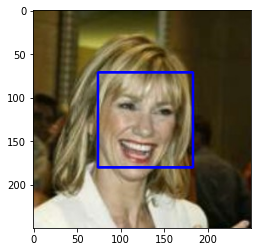

In [0]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
os.system('wget https://raw.githubusercontent.com/arohanajit/deep-learning-v2-pytorch/master/project-dog-classification/haarcascades/haarcascade_frontalface_alt.xml')
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  Our algorithm falls short of this goal, but still gives acceptable performance.

In [0]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
printm()

GPU RAM Free: 14772MB | Used: 1508MB | Util   9% | Total 16280MB


In [0]:
true,true1=0,0
for i,j in zip(human_files_short,dog_files_short):
    if face_detector(i):
        true+=1
    if face_detector(j):
        true1+=1
print("Humans face detection: {}%\nHuman face detection in dogs: {}%".format(true,true1))

Humans face detection: 99%
Human face detection in dogs: 8%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [0]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

We define a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

In [0]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image = Image.open(img_path)
    transform = transforms.Compose([transforms.Resize((250,250)),
                                    transforms.ToTensor()])
    image = transform(image).float()
    image = image.unsqueeze(0)
    #Move to cuda
    image = image.cuda()
    out = torch.argmax(VGG16(image)).cpu().detach().numpy()
    del image
    torch.cuda.empty_cache()

    
    return out # predicted class index

### Dog Detector

In [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), The categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    img_class = VGG16_predict(img_path)
    if img_class>=151 and img_class<=268:
        return True
    else:
        return False

### Assess the Dog Detector

In [0]:
true,true1=0,0
for i,j in zip(human_files_short,dog_files_short):
    if dog_detector(i):
        true+=1
    if dog_detector(j):
        true1+=1
print("Dog face detection in humans: {}%\nDog face detection in dogs: {}%".format(true,true1))
printm()
del VGG16
torch.cuda.empty_cache()

Dog face detection in humans: 0%
Dog face detection in dogs: 100%
GPU RAM Free: 14752MB | Used: 1528MB | Util   9% | Total 16280MB


In [0]:
import torch
import torchvision.models as models
squeezenet = models.squeezenet1_0(pretrained=True)
use_cuda = torch.cuda.is_available()
if use_cuda:
    squeezenet = squeezenet.cuda()

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/checkpoints/squeezenet1_0-a815701f.pth


In [0]:
from PIL import Image
import torchvision.transforms as transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def squeezenet_predict(img_path, squeezenet = squeezenet):
    squeezenet.eval()
    image = Image.open(img_path)
    transform = transforms.Compose([transforms.Resize((250,250)),
                                    transforms.ToTensor()])
    image = transform(image).float()
    image = image.unsqueeze(0)
    image = image.cuda()
    out = torch.argmax(squeezenet(image))
    del image
    return out # predicted class index

In [0]:
def dog_detector(img_path):
    img_class = squeezenet_predict(img_path)
    if img_class>=151 and img_class<=268:
        return True
    else:
        return False

In [0]:
true,true1=0,0
for i,j in zip(human_files_short,dog_files_short):
    if dog_detector(i):
        true+=1
    if dog_detector(j):
        true1+=1
print("Dog face detection in humans: {}%\nDog face detection in dogs: {}%".format(true,true1))
del squeezenet
torch.cuda.empty_cache()

Dog face detection in humans: 2%
Dog face detection in dogs: 78%


---
<a id='step3'></a>
## Step 3: CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we create a CNN that classifies dog breeds from scratch.

Brittany | Welsh Springer Spaniel
- | - 
<img src="https://github.com/arohanajit/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Brittany_02625.jpg?raw=1" width="100"> | <img src="https://github.com/arohanajit/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Welsh_springer_spaniel_08203.jpg?raw=1" width="200">

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="https://github.com/arohanajit/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Curly-coated_retriever_03896.jpg?raw=1" width="200"> | <img src="https://github.com/arohanajit/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/American_water_spaniel_00648.jpg?raw=1" width="200">

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="https://github.com/arohanajit/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Labrador_retriever_06457.jpg?raw=1" width="150"> | <img src="https://github.com/arohanajit/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Labrador_retriever_06455.jpg?raw=1" width="240"> | <img src="https://github.com/arohanajit/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Labrador_retriever_06449.jpg?raw=1" width="220">

### Specify Data Loaders for the Dog Dataset


In [0]:
import os
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

data_dir = 'dogImages'

data_transforms = {
    'train':transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(224),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
    ]),

    'test':transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
    ]),
}
batch_size = 20
dataset = {
    'full' : ImageFolder(data_dir,transform=data_transforms['test']),
    'train' : ImageFolder(data_dir+"/train",transform=data_transforms['train']),
    'valid' : ImageFolder(data_dir+"/valid",transform=data_transforms['test']),
    'test' : ImageFolder(data_dir+"/test",transform=data_transforms['test'])
}

loaders_scratch = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=batch_size, shuffle = True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=batch_size),
    'valid': torch.utils.data.DataLoader(dataset['valid'], batch_size=batch_size),
}

print(len(dataset['full']),len(dataset['train']),len(dataset['test']),len(dataset['valid']))

8351 6680 836 835


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([20, 3, 224, 224]) torch.Size([20])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


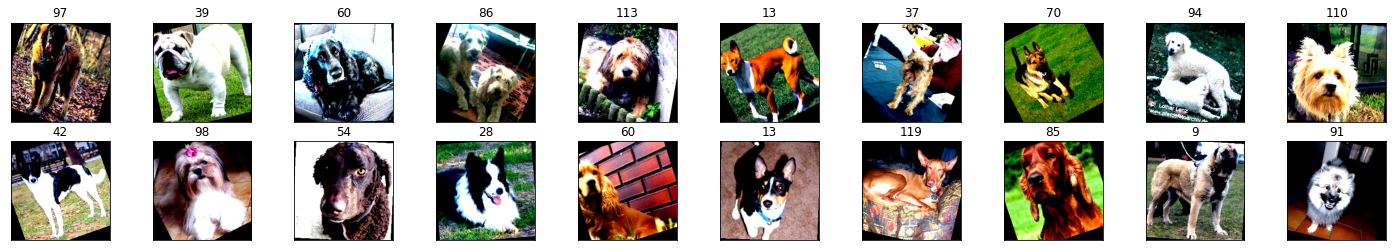

In [0]:
dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
print(images.shape,labels.shape)
images = images.numpy() 
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(int(labels[idx]))

### Model Architecture

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3,16,3,padding=1) 
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        self.conv4 = nn.Conv2d(64,128,3,padding=1)
        self.conv5 = nn.Conv2d(128,256,3,padding=1)

        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.batch_norm5 = nn.BatchNorm2d(256)
        
        
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(256*7*7,1000,bias=True)
        self.fc2 = nn.Linear(1000,133)
        
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.batch_norm1(x)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.batch_norm2(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.batch_norm3(x)

        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.batch_norm4(x)

        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = self.batch_norm5(x)

        x = x.view(-1,256*7*7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)


        return x

# instantiate the CNN
use_cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model_scratch = Net().to(use_cuda)
print(summary(model_scratch,(3,224,224)))
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
         MaxPool2d-5           [-1, 32, 56, 56]               0
       BatchNorm2d-6           [-1, 32, 56, 56]              64
            Conv2d-7           [-1, 64, 56, 56]          18,496
         MaxPool2d-8           [-1, 64, 28, 28]               0
       BatchNorm2d-9           [-1, 64, 28, 28]             128
           Conv2d-10          [-1, 128, 28, 28]          73,856
        MaxPool2d-11          [-1, 128, 14, 14]               0
      BatchNorm2d-12          [-1, 128, 14, 14]             256
           Conv2d-13          [-1, 256, 14, 14]         295,168
        MaxPool2d-14            [-1, 25

### Specify Loss Function and Optimizer

In [0]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

### Train and Validate the Model

In [0]:
def Graphing(train,test):
    plt.plot(train)
    plt.plot(test)
    plt.legend(['Train Loss','Validation Loss'])

Epoch: 1 	Training Loss: 4.935431 	Validation Loss: 4.858918
Validation loss decreased (inf --> 4.858918).  Saving model ...
Epoch: 2 	Training Loss: 4.608373 	Validation Loss: 5.436189
Epoch: 3 	Training Loss: 4.498318 	Validation Loss: 4.581518
Validation loss decreased (4.858918 --> 4.581518).  Saving model ...
Epoch: 4 	Training Loss: 4.386666 	Validation Loss: 4.455027
Validation loss decreased (4.581518 --> 4.455027).  Saving model ...
Epoch: 5 	Training Loss: 4.311630 	Validation Loss: 4.384615
Validation loss decreased (4.455027 --> 4.384615).  Saving model ...
Epoch: 6 	Training Loss: 4.256771 	Validation Loss: 4.211524
Validation loss decreased (4.384615 --> 4.211524).  Saving model ...
Epoch: 7 	Training Loss: 4.191679 	Validation Loss: 4.508584
Epoch: 8 	Training Loss: 4.142781 	Validation Loss: 4.203303
Validation loss decreased (4.211524 --> 4.203303).  Saving model ...
Epoch: 9 	Training Loss: 4.101469 	Validation Loss: 4.094367
Validation loss decreased (4.203303 --> 4.

<All keys matched successfully>

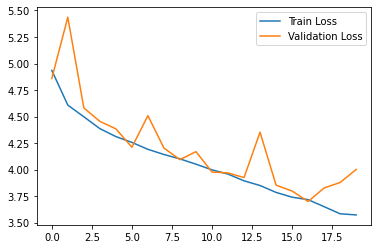

In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm.notebook import tqdm

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train = []
    test = []
    
    for epoch in tqdm(range(1, n_epochs+1)):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        valid_min = 9999
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer_scratch.zero_grad()
            out = model(data)
            loss = criterion_scratch(out,target)
            loss.backward()
            optimizer_scratch.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))


        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion_scratch(output,target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            ## update the average validation loss

            
        train.append(train_loss)
        test.append (valid_loss)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
    # return trained model
    Graphing(train,test)
    return model


# train the model
model_scratch = train(20, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### Test the Model

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.664059


Test Accuracy: 12% (104/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We now use transfer learning to create a CNN that can identify dog breed from images.
### Specify Data Loaders for the Dog Dataset
Dataloaders made previously are used for this model as well

### Model Architecture

In [0]:
import torch
import torchvision.models as models
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Linear(2048, 133, bias=True)
for param in resnet.fc.parameters():
    param.requires_grad = True
use_cuda = torch.cuda.is_available()
print(resnet)
if use_cuda:
    resnet = resnet.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

### Specify Loss Function and Optimizer

In [0]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(resnet.parameters(),lr=0.001)

### Train and Validate the Model

Epoch: 1 	Training Loss: 2.253845 	Validation Loss: 0.919310
Validation loss decreased (inf --> 0.919310).  Saving model ...
Epoch: 2 	Training Loss: 0.877713 	Validation Loss: 0.742266
Validation loss decreased (0.919310 --> 0.742266).  Saving model ...
Epoch: 3 	Training Loss: 0.734957 	Validation Loss: 0.610442
Validation loss decreased (0.742266 --> 0.610442).  Saving model ...
Epoch: 4 	Training Loss: 0.628228 	Validation Loss: 0.668934
Epoch: 5 	Training Loss: 0.580889 	Validation Loss: 0.616742
Epoch: 6 	Training Loss: 0.540879 	Validation Loss: 0.627515
Epoch: 7 	Training Loss: 0.492094 	Validation Loss: 0.607708
Validation loss decreased (0.610442 --> 0.607708).  Saving model ...
Epoch: 8 	Training Loss: 0.476630 	Validation Loss: 0.596799
Validation loss decreased (0.607708 --> 0.596799).  Saving model ...
Epoch: 9 	Training Loss: 0.443683 	Validation Loss: 0.641007
Epoch: 10 	Training Loss: 0.449008 	Validation Loss: 0.681134
Epoch: 11 	Training Loss: 0.436734 	Validation Lo

<All keys matched successfully>

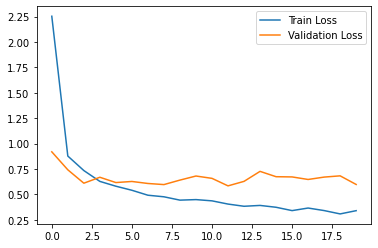

In [0]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm.notebook import tqdm

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train = []
    test = []
    
    for epoch in tqdm(range(1, n_epochs+1)):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        valid_min = 9999
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer_transfer.zero_grad()
            out = model(data)
            loss = criterion_transfer(out,target)
            loss.backward()
            optimizer_transfer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))


        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion_transfer(output,target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            ## update the average validation loss

            
        train.append(train_loss)
        test.append (valid_loss)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
            
    # return trained model
    Graphing(train,test)
    return model


# train the model
train(20, loaders_scratch, resnet, optimizer_transfer, 
                      criterion_transfer, use_cuda, 'resnet.pt')

# load the model that got the best validation accuracy
resnet.load_state_dict(torch.load('resnet.pt'))

### Test the Model

In [0]:
test(loaders_scratch, resnet, criterion_transfer, use_cuda)

Test Loss: 0.589754


Test Accuracy: 82% (691/836)


### Predict Dog Breed with the Model

Function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by our model.  

In [0]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in dataset['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path)
    transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).float()
    image = image.unsqueeze(0)
    #Move to cuda
    image = image.cuda()
    out = torch.argmax(resnet(image)).cpu().detach().numpy()
    del image
    torch.cuda.empty_cache()

    
    return out # predicted class index

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Algorithm accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.
### Write your Algorithm

In [0]:
def display(img_path):
    plt.axis('off')
    plt.imshow(plt.imread(img_path))

In [0]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    display(img_path)
    if face_detector(img_path):
        lbl = predict_breed_transfer(img_path)
        print("Hello Human! You look like a {}".format(class_names[lbl]))
    elif dog_detector(img_path):
        lbl = predict_breed_transfer(img_path)
        print("Hello Dog! You look like a {}".format(class_names[lbl]))
    else:
        print("What kind of animal are you?")




---
<a id='step6'></a>
## Step 6: Test Algorithm

### (IMPLEMENTATION) Testing Algorithm on Sample Images!

Hello Human! You look like a Finnish spitz


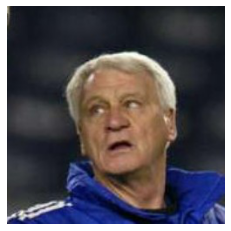

In [0]:
run_app(human_files[2])

Hello Human! You look like a American water spaniel


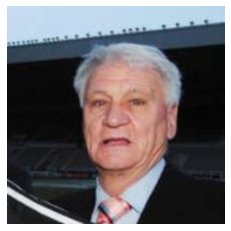

In [0]:
run_app(human_files[1])

Hello Human! You look like a Pharaoh hound


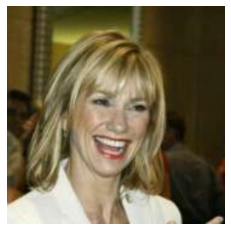

In [0]:
run_app(human_files[0])

Hello Dog! You look like a Cairn terrier


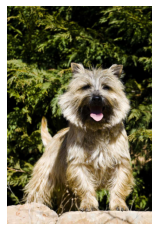

In [0]:
run_app(dog_files[0])

What kind of animal are you?


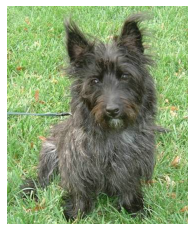

In [0]:
run_app(dog_files[1])

Hello Dog! You look like a Cairn terrier


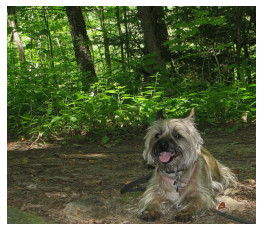

In [0]:
run_app(dog_files[2])